# CLuster de Usuarios

1. Feature engeneering, agregacoes por hora, sessao e dia,
2. nao criar a feature de risco
3. clusterizar jogadores, com alguma metrica, gadam
4. estudar o cluster mais saudavel
5. criar o autoencoder desse cluster
6. ver a distancia do cluster ao longo do tempo
7. prever essa distancia no futuro como um ts







In [ ]:

import pandas as pd
import numpy as np
import gc

from scipy.stats import linregress

# from sklearn import metrics
from sklearn.preprocessing import StandardScaler, RobustScaler
# from sklearn.metrics import silhouette_score, mean_absolute_error, r2_score
# from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# import hdbscan
# from hdbscan import prediction
# from itertools import product

from pycaret.clustering import *

# from lightgbm import LGBMRegressor, plot_importance

from helper.model_plots import *
#plots personalizados



In [144]:
usecols = ['game_id', 'user_id', 'bet_id', 'game_type', 'odds', 'fiat_bet_amount',
       'fiat_profit_amount','fiat_is_valuable']


bets_dtypes = {
    'game_id': 'uint32',
    'user_id': 'uint32',
    'bet_id': 'uint64',
    'game_type': 'category',
    'odds': 'float32',
    'fiat_is_valuable': 'category',
    'fiat_bet_amount': 'float32',
    'fiat_profit_amount': 'float32',
}

bets = pd.read_csv("data/bets.csv", usecols=usecols, dtype=bets_dtypes)
bets = bets[bets['fiat_is_valuable'] == 't']


In [145]:
bets.head()


game_id  user_id     bet_id game_type  odds fiat_is_valuable  \
0  2828375   173570  210854317    normal   0.0                t   
2  2828375  1139219  210854260    normal   2.0                t   
3  2828375  1329183   12148544    yellow   0.0                t   
4  2828375  1378328  210854292    normal   0.0                t   
5  2828375  1420292  210854342    normal   3.0                t   

   fiat_bet_amount  fiat_profit_amount  
0         0.048738           -0.048738  
2         0.000088            0.000088  
3         0.188109           -0.188109  
4         0.000005           -0.000005  
5         0.000107            0.000213

In [146]:
games_usecols = ['game_id', 'max_rate', 'date'] # ,'bet_count']

games_dtypes = {
    'game_id': 'uint32',
    'max_rate': 'float32',
    # 'bet_count': 'uint32',
}

games = pd.read_csv("data/games.csv", usecols=games_usecols, dtype=games_dtypes, parse_dates=['date'])


In [147]:

games.head()


game_id   max_rate                date
0  2828375   6.430000 2020-09-08 23:30:13
1  2828376   2.100000 2020-09-08 23:30:35
2  2828377   3.110000 2020-09-08 23:31:03
3  2828378  24.969999 2020-09-08 23:32:07
4  2828379   1.040000 2020-09-08 23:32:17

In [148]:
df = pd.merge(bets, games, on='game_id', how='left')



In [149]:
del bets, games
gc.collect()


0

In [150]:
df.sort_values(['user_id','game_id'], kind='stable', inplace=True, ignore_index=True)



In [151]:
df.head()


game_id  user_id     bet_id game_type  odds fiat_is_valuable  \
0  2831698       44  212042687    normal  1.03                t   
1  2831768       44  212067364    normal  1.03                t   
2  2831820       44  212085405    normal  1.08                t   
3  2832628       44  212376980    normal  1.67                t   
4  2832686       44  212397916    normal  2.00                t   

   fiat_bet_amount  fiat_profit_amount    max_rate                date  
0         0.000034            0.000001    2.370000 2020-09-09 22:51:14  
1         0.000034            0.000001    2.070000 2020-09-09 23:26:45  
2         0.000034            0.000003    1.150000 2020-09-09 23:48:26  
3         0.000035            0.000024    2.060000 2020-09-10 05:36:11  
4         0.000140            0.000140  328.890015 2020-09-10 06:01:38

In [152]:
df.columns


Index(['game_id', 'user_id', 'bet_id', 'game_type', 'odds', 'fiat_is_valuable',
       'fiat_bet_amount', 'fiat_profit_amount', 'max_rate', 'date'],
      dtype='object')

In [153]:
df = df.drop(columns=['fiat_is_valuable'])


In [154]:
df.head(20)


game_id  user_id     bet_id game_type  odds  fiat_bet_amount  \
0   2831698       44  212042687    normal  1.03         0.000034   
1   2831768       44  212067364    normal  1.03         0.000034   
2   2831820       44  212085405    normal  1.08         0.000034   
3   2832628       44  212376980    normal  1.67         0.000035   
4   2832686       44  212397916    normal  2.00         0.000140   
5   2832689       44  212399028    normal  0.00         0.000140   
6   2832690       44  212399332    normal  2.00         0.000281   
7   2832691       44  212399705    normal  2.00         0.000140   
8   2837444       44  214069523    normal  1.03         0.000037   
9   2843418       44  216156160    normal  1.02         0.000039   
10  2843797       44  216305425    normal  1.08         0.000039   
11  2843800       44  216306551    normal  1.02         0.000155   
12  2844658       44  216602839    normal  1.03         0.000039   
13  2851773       44  219109074    normal  1.06         0.000038   
14  2851775       44  219109971    normal  1.05         0.000038   
15  2851776       44  219110308    normal  1.40         0.000038   
16  2851777       44  219110641    normal  1.06         0.000038   
17  2851779       44  219111184    normal  1.02         0.000038   
18  2851780       44  219111708    normal  1.16         0.000038   
19  2851781       44  219112030    normal  1.07         0.000038   

    fiat_profit_amount    max_rate                date  
0         1.013535e-06    2.370000 2020-09-09 22:51:14  
1         1.013535e-06    2.070000 2020-09-09 23:26:45  
2         2.702760e-06    1.150000 2020-09-09 23:48:26  
3         2.353256e-05    2.060000 2020-09-10 05:36:11  
4         1.404929e-04  328.890015 2020-09-10 06:01:38  
5        -1.404929e-04    1.100000 2020-09-10 06:02:47  
6         2.809858e-04    2.950000 2020-09-10 06:03:14  
7         1.404929e-04    7.670000 2020-09-10 06:03:57  
8         1.102917e-06    3.310000 2020-09-11 15:26:11  
9         7.754470e-07    4.460000 2020-09-13 10:25:25  
10        3.101788e-06    6.430000 2020-09-13 13:09:44  
11        3.101788e-06    1.370000 2020-09-13 13:10:20  
12        1.163171e-06    2.270000 2020-09-13 19:30:31  
13        2.258367e-06    1.630000 2020-09-15 22:25:37  
14        1.881973e-06    1.250000 2020-09-15 22:26:02  
15        1.505578e-05    1.510000 2020-09-15 22:26:18  
16        2.258367e-06    9.070000 2020-09-15 22:27:07  
17        7.527891e-07    1.520000 2020-09-15 22:28:07  
18        6.022313e-06    5.150000 2020-09-15 22:28:56  
19        2.634762e-06    1.250000 2020-09-15 22:29:09

In [155]:
conditions = [
    (df['game_type'] == 'normal') & (df['odds'] == 0),
    (df['game_type'] == 'green'),
    (df['game_type'] == 'red'),
    (df['game_type'] == 'yellow')
]

values = [
    df['max_rate'],
    2,
    1.96,
    10
]

df['odds_adjusted'] = np.select(conditions, values, default=df['odds'])


In [156]:
df.head()


game_id  user_id     bet_id game_type  odds  fiat_bet_amount  \
0  2831698       44  212042687    normal  1.03         0.000034   
1  2831768       44  212067364    normal  1.03         0.000034   
2  2831820       44  212085405    normal  1.08         0.000034   
3  2832628       44  212376980    normal  1.67         0.000035   
4  2832686       44  212397916    normal  2.00         0.000140   

   fiat_profit_amount    max_rate                date  odds_adjusted  
0            0.000001    2.370000 2020-09-09 22:51:14           1.03  
1            0.000001    2.070000 2020-09-09 23:26:45           1.03  
2            0.000003    1.150000 2020-09-09 23:48:26           1.08  
3            0.000024    2.060000 2020-09-10 05:36:11           1.67  
4            0.000140  328.890015 2020-09-10 06:01:38           2.00

In [157]:
df.user_id.nunique(), df.game_id.nunique(), df.bet_id.nunique()



(32102, 71499, 23335924)

In [158]:
past_bets = df.groupby("user_id")["fiat_bet_amount"].shift(1)

df["user_bet_mean_weighted"] = (
    past_bets
    .groupby(df["user_id"])
    .transform(lambda s: s.ewm(alpha=0.01, adjust=False).mean())
)
df["user_bet_mean_weighted"] = df["user_bet_mean_weighted"].fillna(
    df.groupby("user_id")["fiat_bet_amount"].transform("first")
)

df["user_bet_amount_proportion"] = df["fiat_bet_amount"] / df["user_bet_mean_weighted"]


In [159]:
df.head(10)


game_id  user_id     bet_id game_type  odds  fiat_bet_amount  \
0  2831698       44  212042687    normal  1.03         0.000034   
1  2831768       44  212067364    normal  1.03         0.000034   
2  2831820       44  212085405    normal  1.08         0.000034   
3  2832628       44  212376980    normal  1.67         0.000035   
4  2832686       44  212397916    normal  2.00         0.000140   
5  2832689       44  212399028    normal  0.00         0.000140   
6  2832690       44  212399332    normal  2.00         0.000281   
7  2832691       44  212399705    normal  2.00         0.000140   
8  2837444       44  214069523    normal  1.03         0.000037   
9  2843418       44  216156160    normal  1.02         0.000039   

   fiat_profit_amount    max_rate                date  odds_adjusted  \
0        1.013535e-06    2.370000 2020-09-09 22:51:14           1.03   
1        1.013535e-06    2.070000 2020-09-09 23:26:45           1.03   
2        2.702760e-06    1.150000 2020-09-09 23:48:26           1.08   
3        2.353256e-05    2.060000 2020-09-10 05:36:11           1.67   
4        1.404929e-04  328.890015 2020-09-10 06:01:38           2.00   
5       -1.404929e-04    1.100000 2020-09-10 06:02:47           1.10   
6        2.809858e-04    2.950000 2020-09-10 06:03:14           2.00   
7        1.404929e-04    7.670000 2020-09-10 06:03:57           2.00   
8        1.102917e-06    3.310000 2020-09-11 15:26:11           1.03   
9        7.754470e-07    4.460000 2020-09-13 10:25:25           1.02   

   user_bet_mean_weighted  user_bet_amount_proportion  
0                0.000034                    1.000000  
1                0.000034                    1.000000  
2                0.000034                    1.000000  
3                0.000034                    1.039625  
4                0.000034                    4.156854  
5                0.000035                    4.029644  
6                0.000036                    7.822300  
7                0.000038                    3.661361  
8                0.000039                    0.933260  
9                0.000039                    0.984903

In [160]:
gamma = 0.8
delta = 0.2
raw = gamma * np.log(df["odds_adjusted"]) + delta * np.log(df["user_bet_amount_proportion"])
# raw = np.log(df["odds_adjusted"] * df["user_bet_amount_proportion"])

mu = raw.mean()
sd = raw.std() + 1e-12
df["bet_risk"] = (raw - mu) / sd 





In [161]:
df["odds_log"] = np.log(df["odds_adjusted"])
df["bets_log"] = np.log(df["user_bet_amount_proportion"])


In [162]:

df.head(100)


game_id  user_id     bet_id game_type  odds  fiat_bet_amount  \
0   2831698       44  212042687    normal  1.03         0.000034   
1   2831768       44  212067364    normal  1.03         0.000034   
2   2831820       44  212085405    normal  1.08         0.000034   
3   2832628       44  212376980    normal  1.67         0.000035   
4   2832686       44  212397916    normal  2.00         0.000140   
..      ...      ...        ...       ...   ...              ...   
95  2828664     5588   12159782    yellow  0.00         7.090167   
96  2828665     5588   12159820       red  0.00         1.772542   
97  2828665     5588   12159822     green  2.00         0.886271   
98  2828666     5588   12159859     green  2.00         7.090167   
99  2828666     5588   12159862       red  0.00         3.545083   

    fiat_profit_amount    max_rate                date  odds_adjusted  \
0             0.000001    2.370000 2020-09-09 22:51:14           1.03   
1             0.000001    2.070000 2020-09-09 23:26:45           1.03   
2             0.000003    1.150000 2020-09-09 23:48:26           1.08   
3             0.000024    2.060000 2020-09-10 05:36:11           1.67   
4             0.000140  328.890015 2020-09-10 06:01:38           2.00   
..                 ...         ...                 ...            ...   
95           -7.090167    2.410000 2020-09-09 01:32:42          10.00   
96           -1.772542    7.400000 2020-09-09 01:33:25           1.96   
97            0.886271    7.400000 2020-09-09 01:33:25           2.00   
98            7.090167    3.030000 2020-09-09 01:33:52           2.00   
99           -3.545083    3.030000 2020-09-09 01:33:52           1.96   

    user_bet_mean_weighted  user_bet_amount_proportion  bet_risk  odds_log  \
0                 0.000034                    1.000000 -0.103505  0.029559   
1                 0.000034                    1.000000 -0.103505  0.029559   
2                 0.000034                    1.000000 -0.048888  0.076961   
3                 0.000034                    1.039625  0.464507  0.512824   
4                 0.000034                    4.156854  1.071484  0.693147   
..                     ...                         ...       ...       ...   
95                4.320677                    1.640985  2.658147  2.302585   
96                4.348371                    0.407633  0.379312  0.672944   
97                4.322613                    0.205031  0.204640  0.693147   
98                4.288250                    1.653394  0.805922  0.693147   
99                4.316269                    0.821330  0.581108  0.672944   

    bets_log  
0   0.000000  
1   0.000000  
2   0.000000  
3   0.038860  
4   1.424759  
..       ...  
95  0.495297  
96 -0.897387  
97 -1.584593  
98  0.502830  
99 -0.196830  

[100 rows x 15 columns]

In [163]:
# df['time'] = df['date'].dt.time
df['hour'] = df['date'].dt.hour
# df['day'] = df['date'].dt.date
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week





In [164]:
df.head()


game_id  user_id     bet_id game_type  odds  fiat_bet_amount  \
0  2831698       44  212042687    normal  1.03         0.000034   
1  2831768       44  212067364    normal  1.03         0.000034   
2  2831820       44  212085405    normal  1.08         0.000034   
3  2832628       44  212376980    normal  1.67         0.000035   
4  2832686       44  212397916    normal  2.00         0.000140   

   fiat_profit_amount    max_rate                date  odds_adjusted  \
0            0.000001    2.370000 2020-09-09 22:51:14           1.03   
1            0.000001    2.070000 2020-09-09 23:26:45           1.03   
2            0.000003    1.150000 2020-09-09 23:48:26           1.08   
3            0.000024    2.060000 2020-09-10 05:36:11           1.67   
4            0.000140  328.890015 2020-09-10 06:01:38           2.00   

   user_bet_mean_weighted  user_bet_amount_proportion  bet_risk  odds_log  \
0                0.000034                    1.000000 -0.103505  0.029559   
1                0.000034                    1.000000 -0.103505  0.029559   
2                0.000034                    1.000000 -0.048888  0.076961   
3                0.000034                    1.039625  0.464507  0.512824   
4                0.000034                    4.156854  1.071484  0.693147   

   bets_log  hour  day_of_week  day_of_year  week_of_year  
0  0.000000    22            2          253            37  
1  0.000000    23            2          253            37  
2  0.000000    23            2          253            37  
3  0.038860     5            3          254            37  
4  1.424759     6            3          254            37

In [165]:
def downcast_df(df: pd.DataFrame) -> pd.DataFrame:
    float_cols = df.select_dtypes(include=['float64','float32']).columns
    df[float_cols] = df[float_cols].astype('float32', copy=False)

    int_cols = df.select_dtypes(include=['int64','int32','int']).columns
    for c in int_cols:
        if df[c].min() >= 0 and df[c].max() <= np.iinfo(np.uint32).max:
            df[c] = df[c].astype('uint32', copy=False)
        else:
            df[c] = df[c].astype('int32', copy=False)


    if 'user_id' in df.columns:
        df['user_id'] = df['user_id'].astype('category')


    if 'game_id' in df.columns:
        df['game_id'] = df['game_id'].astype('category')

    gc.collect()
    return df


In [166]:
df = downcast_df(df)


In [167]:
df.head()


game_id user_id     bet_id game_type  odds  fiat_bet_amount  \
0  2831698      44  212042687    normal  1.03         0.000034   
1  2831768      44  212067364    normal  1.03         0.000034   
2  2831820      44  212085405    normal  1.08         0.000034   
3  2832628      44  212376980    normal  1.67         0.000035   
4  2832686      44  212397916    normal  2.00         0.000140   

   fiat_profit_amount    max_rate                date  odds_adjusted  \
0            0.000001    2.370000 2020-09-09 22:51:14           1.03   
1            0.000001    2.070000 2020-09-09 23:26:45           1.03   
2            0.000003    1.150000 2020-09-09 23:48:26           1.08   
3            0.000024    2.060000 2020-09-10 05:36:11           1.67   
4            0.000140  328.890015 2020-09-10 06:01:38           2.00   

   user_bet_mean_weighted  user_bet_amount_proportion  bet_risk  odds_log  \
0                0.000034                    1.000000 -0.103505  0.029559   
1                0.000034                    1.000000 -0.103505  0.029559   
2                0.000034                    1.000000 -0.048888  0.076961   
3                0.000034                    1.039625  0.464507  0.512824   
4                0.000034                    4.156854  1.071484  0.693147   

   bets_log  hour  day_of_week  day_of_year  week_of_year  
0  0.000000    22            2          253            37  
1  0.000000    23            2          253            37  
2  0.000000    23            2          253            37  
3  0.038860     5            3          254            37  
4  1.424759     6            3          254            37

In [168]:
# df = df.drop(columns=['game_type','odds','max_rate','odds_adjusted','user_bet_amount_proportion','user_bet_mean_weighted'])
df = df.drop(columns=['game_type','odds','max_rate','user_bet_mean_weighted'])
df.head()


game_id user_id     bet_id  fiat_bet_amount  fiat_profit_amount  \
0  2831698      44  212042687         0.000034            0.000001   
1  2831768      44  212067364         0.000034            0.000001   
2  2831820      44  212085405         0.000034            0.000003   
3  2832628      44  212376980         0.000035            0.000024   
4  2832686      44  212397916         0.000140            0.000140   

                 date  odds_adjusted  user_bet_amount_proportion  bet_risk  \
0 2020-09-09 22:51:14           1.03                    1.000000 -0.103505   
1 2020-09-09 23:26:45           1.03                    1.000000 -0.103505   
2 2020-09-09 23:48:26           1.08                    1.000000 -0.048888   
3 2020-09-10 05:36:11           1.67                    1.039625  0.464507   
4 2020-09-10 06:01:38           2.00                    4.156854  1.071484   

   odds_log  bets_log  hour  day_of_week  day_of_year  week_of_year  
0  0.029559  0.000000    22            2          253            37  
1  0.029559  0.000000    23            2          253            37  
2  0.076961  0.000000    23            2          253            37  
3  0.512824  0.038860     5            3          254            37  
4  0.693147  1.424759     6            3          254            37

In [169]:
bets = df.copy()


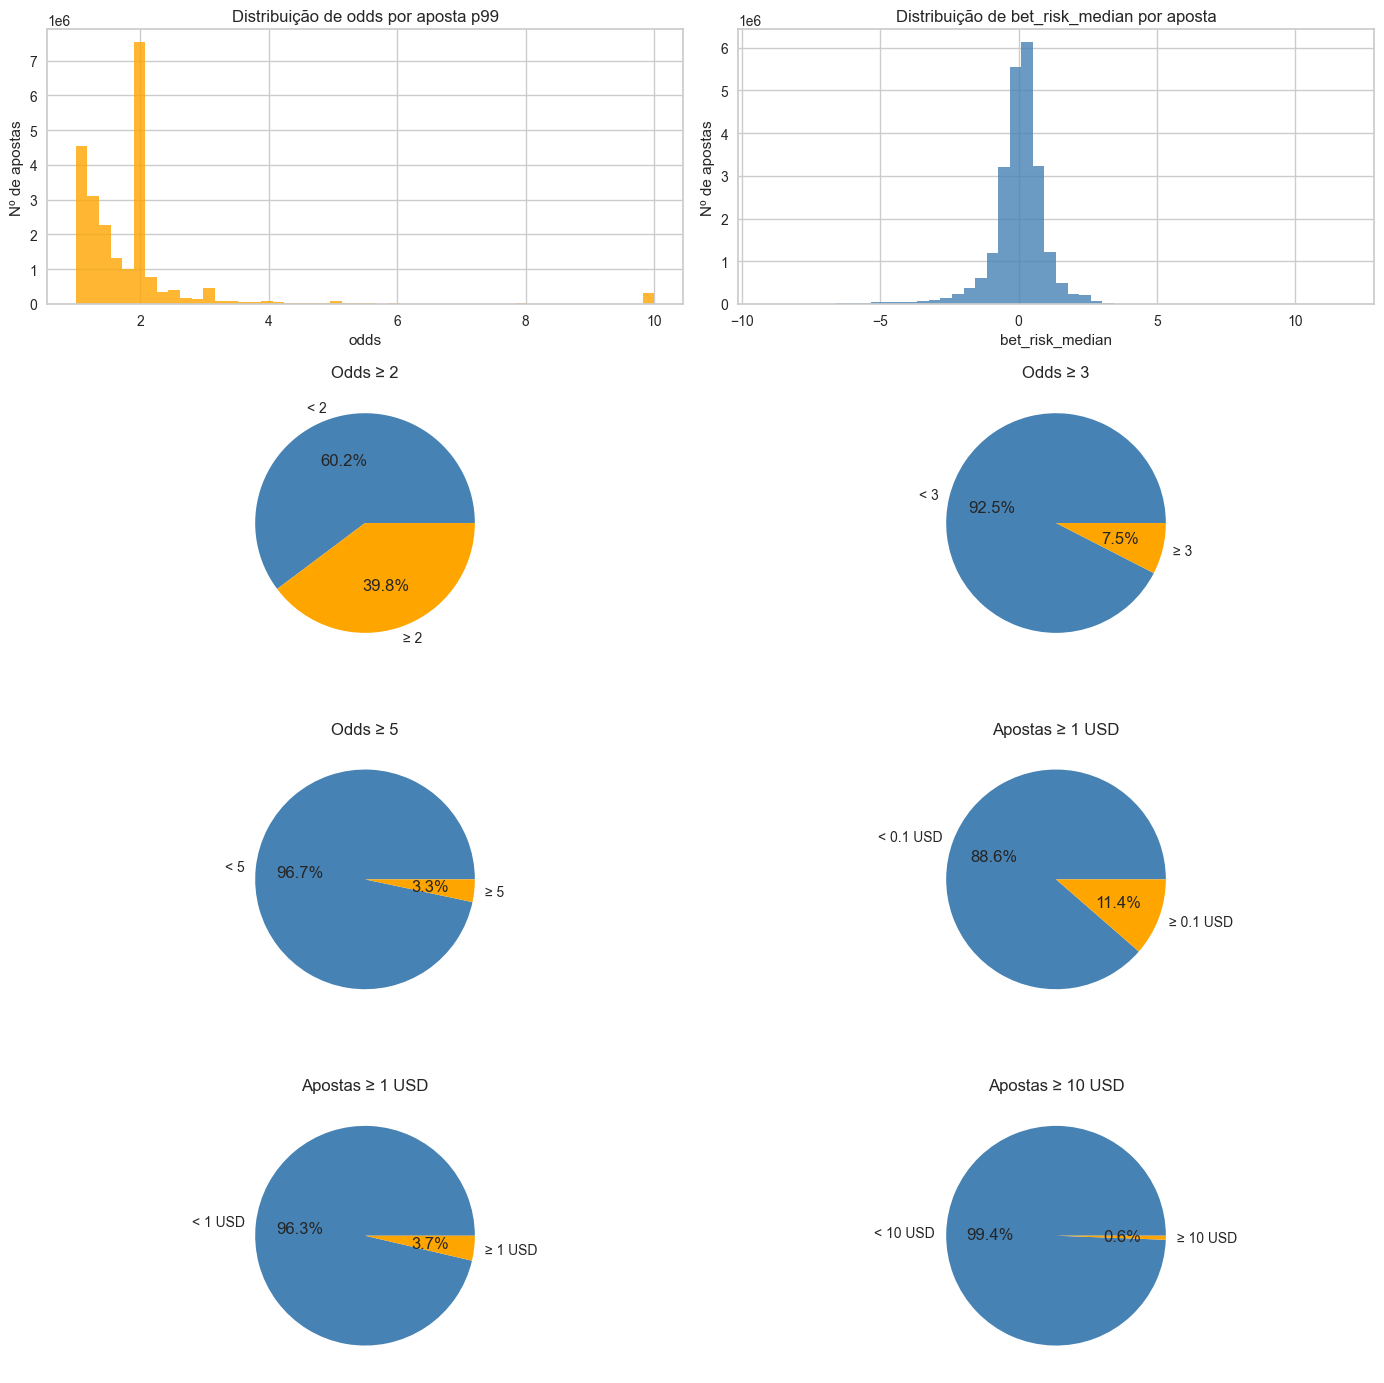

In [170]:
plot_bets_analisys(bets)


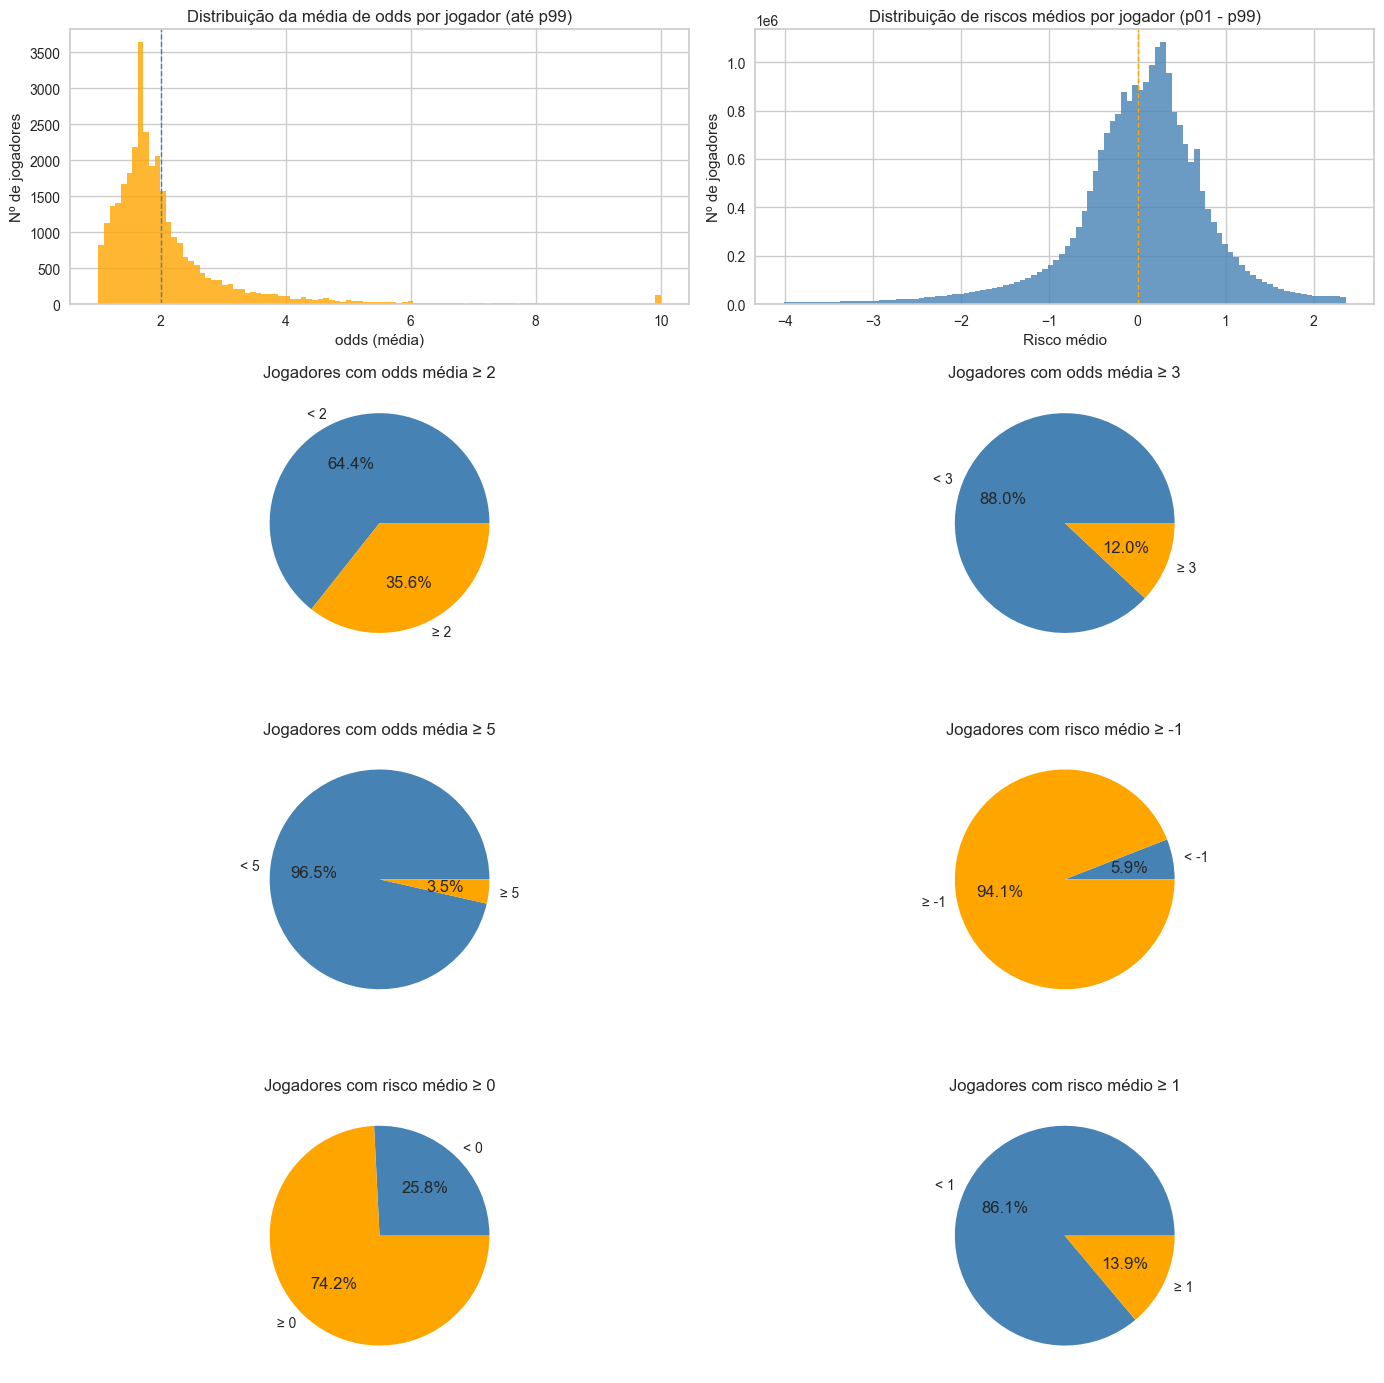

In [171]:
plot_users_dash(df)


In [172]:
df.head()


game_id user_id     bet_id  fiat_bet_amount  fiat_profit_amount  \
0  2831698      44  212042687         0.000034            0.000001   
1  2831768      44  212067364         0.000034            0.000001   
2  2831820      44  212085405         0.000034            0.000003   
3  2832628      44  212376980         0.000035            0.000024   
4  2832686      44  212397916         0.000140            0.000140   

                 date  odds_adjusted  user_bet_amount_proportion  bet_risk  \
0 2020-09-09 22:51:14           1.03                    1.000000 -0.103505   
1 2020-09-09 23:26:45           1.03                    1.000000 -0.103505   
2 2020-09-09 23:48:26           1.08                    1.000000 -0.048888   
3 2020-09-10 05:36:11           1.67                    1.039625  0.464507   
4 2020-09-10 06:01:38           2.00                    4.156854  1.071484   

   odds_log  bets_log  hour  day_of_week  day_of_year  week_of_year  
0  0.029559  0.000000    22            2          253            37  
1  0.029559  0.000000    23            2          253            37  
2  0.076961  0.000000    23            2          253            37  
3  0.512824  0.038860     5            3          254            37  
4  0.693147  1.424759     6            3          254            37

In [173]:
m24_odd = (df.groupby(['user_id','day_of_year','hour'], observed=True)['odds_adjusted']
         .mean()
         .unstack('hour', fill_value=0))
m24_odd = m24_odd.reindex(columns=list(range(24)), fill_value=0)

m24_bet = (df.groupby(['user_id','day_of_year','hour'], observed=True)['user_bet_amount_proportion']
         .mean()
         .unstack('hour', fill_value=0))
m24_bet = m24_bet.reindex(columns=list(range(24)), fill_value=0)
m24_bet.head()


hour                  0    1    2    3    4         5        6    7    8   \
user_id day_of_year                                                         
44      253          0.0  0.0  0.0  0.0  0.0  0.000000  0.00000  0.0  0.0   
        254          0.0  0.0  0.0  0.0  0.0  1.039625  4.91754  0.0  0.0   
        255          0.0  0.0  0.0  0.0  0.0  0.000000  0.00000  0.0  0.0   
        257          0.0  0.0  0.0  0.0  0.0  0.000000  0.00000  0.0  0.0   
        259          0.0  0.0  0.0  0.0  0.0  0.000000  0.00000  0.0  0.0   

hour                  9   ...   14       15   16   17   18        19   20  \
user_id day_of_year       ...                                               
44      253          0.0  ...  0.0  0.00000  0.0  0.0  0.0  0.000000  0.0   
        254          0.0  ...  0.0  0.00000  0.0  0.0  0.0  0.000000  0.0   
        255          0.0  ...  0.0  0.93326  0.0  0.0  0.0  0.000000  0.0   
        257          0.0  ...  0.0  0.00000  0.0  0.0  0.0  0.957054  0.0   
        259          0.0  ...  0.0  0.00000  0.0  0.0  0.0  0.000000  0.0   

hour                  21        22   23  
user_id day_of_year                      
44      253          0.0  1.000000  1.0  
        254          0.0  0.000000  0.0  
        255          0.0  0.000000  0.0  
        257          0.0  0.000000  0.0  
        259          0.0  0.933912  0.0  

[5 rows x 24 columns]

In [174]:

m24_bet = m24_bet.div(m24_bet.sum(axis=1), axis=0)
m24_bet.head()


hour                  0    1    2    3    4         5         6    7    8   \
user_id day_of_year                                                          
44      253          0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0   
        254          0.0  0.0  0.0  0.0  0.0  0.174517  0.825483  0.0  0.0   
        255          0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0   
        257          0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0   
        259          0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0   

hour                  9   ...   14   15   16   17   18        19   20   21  \
user_id day_of_year       ...                                                
44      253          0.0  ...  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
        254          0.0  ...  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
        255          0.0  ...  0.0  1.0  0.0  0.0  0.0  0.000000  0.0  0.0   
        257          0.0  ...  0.0  0.0  0.0  0.0  0.0  0.217271  0.0  0.0   
        259          0.0  ...  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   

hour                  22   23  
user_id day_of_year            
44      253          0.5  0.5  
        254          0.0  0.0  
        255          0.0  0.0  
        257          0.0  0.0  
        259          1.0  0.0  

[5 rows x 24 columns]

In [175]:

m24_odd = m24_odd.div(m24_odd.sum(axis=1), axis=0)
m24_odd.head()


hour                  0    1    2    3    4         5         6    7    8   \
user_id day_of_year                                                          
44      253          0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0   
        254          0.0  0.0  0.0  0.0  0.0  0.484761  0.515239  0.0  0.0   
        255          0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0   
        257          0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0   
        259          0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0   

hour                  9   ...   14   15   16   17   18        19   20   21  \
user_id day_of_year       ...                                                
44      253          0.0  ...  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
        254          0.0  ...  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
        255          0.0  ...  0.0  1.0  0.0  0.0  0.0  0.000000  0.0  0.0   
        257          0.0  ...  0.0  0.0  0.0  0.0  0.0  0.332258  0.0  0.0   
        259          0.0  ...  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   

hour                       22        23  
user_id day_of_year                      
44      253          0.494005  0.505995  
        254          0.000000  0.000000  
        255          0.000000  0.000000  
        257          0.000000  0.000000  
        259          1.000000  0.000000  

[5 rows x 24 columns]

In [176]:
def agg_hours(hours,name):
    # min  = hours.min(axis=1).rename(f"{name}_min_hours%")
    max  = hours.max(axis=1).rename(f"{name}_top1hour%")
    # std  = hours.std(axis=1).rename(f"{name}_std_hours%")

    p = hours.to_numpy()
    top2 = np.sort(p, axis=1)[:, -2:]
    top2_sum = pd.Series(top2.sum(axis=1), index=hours.index, name=f"{name}_top2hours%")

    top4 = np.sort(p, axis=1)[:, -2:]
    top4_sum = pd.Series(top4.sum(axis=1), index=hours.index, name=f"{name}_top4hours%")

    uniform = 1.0 / 24.0
    mean_abs_dev_uniform = (
        hours.sub(uniform).abs().mean(axis=1).rename(f"{name}_mean_abs_dev_uniform%")
    )

    hour_features_daily = pd.concat(
        [
            # min,
            max,
            # std,
            top2_sum,
            top4_sum,
            mean_abs_dev_uniform,
        ],
        axis=1,
    )
    return hour_features_daily


In [177]:
bet_hour_agg = agg_hours(m24_bet,'bet')
odd_hour_agg = agg_hours(m24_odd,'odd')


In [178]:
bet_hour_agg


bet_top1hour%  bet_top2hours%  bet_top4hours%  \
user_id day_of_year                                                  
44      253               0.500000        1.000000        1.000000   
        254               0.825483        1.000000        1.000000   
        255               1.000000        1.000000        1.000000   
        257               0.559135        0.782729        0.782729   
        259               1.000000        1.000000        1.000000   
...                            ...             ...             ...   
1503508 274               1.000000        1.000000        1.000000   
1503513 274               1.000000        1.000000        1.000000   
1503516 274               1.000000        1.000000        1.000000   
1503542 274               1.000000        1.000000        1.000000   
1503546 274               1.000000        1.000000        1.000000   

                     bet_mean_abs_dev_uniform%  
user_id day_of_year                             
44      253                           0.076389  
        254                           0.076389  
        255                           0.079861  
        257                           0.072917  
        259                           0.079861  
...                                        ...  
1503508 274                           0.079861  
1503513 274                           0.079861  
1503516 274                           0.079861  
1503542 274                           0.079861  
1503546 274                           0.079861  

[130644 rows x 4 columns]

In [179]:
n_hours = pd.Series((m24_odd != 0).sum(axis=1))
n_hours.name = 'n_active_hours'
n_hours.head()


user_id  day_of_year
44       253            2
         254            2
         255            1
         257            3
         259            1
Name: n_active_hours, dtype: int64

In [180]:
df['gap_min'] = df.groupby('user_id')['date'].diff().dt.total_seconds().div(60)
threshold_min = 60
df['new_session'] = df['gap_min'].isna() | (df['gap_min'] > threshold_min)
df['session_id'] = df.groupby('user_id')['new_session'].cumsum().astype('int64')
df.drop(columns=['gap_min','new_session'], inplace=True)
df.head()


game_id user_id     bet_id  fiat_bet_amount  fiat_profit_amount  \
0  2831698      44  212042687         0.000034            0.000001   
1  2831768      44  212067364         0.000034            0.000001   
2  2831820      44  212085405         0.000034            0.000003   
3  2832628      44  212376980         0.000035            0.000024   
4  2832686      44  212397916         0.000140            0.000140   

                 date  odds_adjusted  user_bet_amount_proportion  bet_risk  \
0 2020-09-09 22:51:14           1.03                    1.000000 -0.103505   
1 2020-09-09 23:26:45           1.03                    1.000000 -0.103505   
2 2020-09-09 23:48:26           1.08                    1.000000 -0.048888   
3 2020-09-10 05:36:11           1.67                    1.039625  0.464507   
4 2020-09-10 06:01:38           2.00                    4.156854  1.071484   

   odds_log  bets_log  hour  day_of_week  day_of_year  week_of_year  \
0  0.029559  0.000000    22            2          253            37   
1  0.029559  0.000000    23            2          253            37   
2  0.076961  0.000000    23            2          253            37   
3  0.512824  0.038860     5            3          254            37   
4  0.693147  1.424759     6            3          254            37   

   session_id  
0           1  
1           1  
2           1  
3           2  
4           2

In [181]:

basic = (df.groupby(['user_id','day_of_year'], observed=True)
           .agg(
               odds_log_mean=('odds_log','mean'),
               odds_log_std=('odds_log','std'),
               
               bet_prop_log_mean=('bets_log','mean'),
               bet_prop_log_std=('bets_log','std'),
               
               
               n_bets=('bet_id','size'),
            #    bet_sum=('fiat_bet_amount','sum'),
            #    profit_sum=('fiat_profit_amount','sum'),
               n_sessions=('session_id','nunique'),
           )
           .fillna(0.0)
           .astype('float32'))

basic.head()


odds_log_mean  odds_log_std  bet_prop_log_mean  \
user_id day_of_year                                                   
44      253               0.045360      0.027368           0.000000   
        254               0.537515      0.259239           1.242422   
        255               0.029559      0.000000          -0.069071   
        257               0.036531      0.027343           0.324303   
        259               0.095418      0.104053          -0.068377   

                     bet_prop_log_std  n_bets  n_sessions  
user_id day_of_year                                        
44      253                  0.000000     3.0         1.0  
        254                  0.736760     5.0         1.0  
        255                  0.000000     1.0         1.0  
        257                  0.698184     4.0         3.0  
        259                  0.002970    15.0         1.0

In [182]:
hours = np.arange(24)

def slope(grp, column):
    y = (grp.groupby('hour')[column]
            .sum()
            .reindex(range(24), fill_value=0)
            .values)
    return float(linregress(hours, y).slope)

slope_bet = (
    df
    .groupby(['user_id','day_of_year'], observed=True)
    .apply(lambda g: slope(g, column='bets_log'))
    .rename('slope_bet')
)

slope_odd = (
    df
    .groupby(['user_id','day_of_year'], observed=True)
    .apply(lambda g: slope(g, column='odds_log'))
    .rename('slope_odd')
)


In [183]:
slope_bet.name = 'slope_bet_day'
slope_odd.name = 'slope_odd_day'


In [184]:
slope_bet.sort_values(ascending=False)


user_id  day_of_year
967686   273            111.463481
146999   258            109.099027
965030   256             96.408246
1407054  262             93.239670
673274   273             90.372611
                           ...    
368729   258            -90.542799
1343144  262            -94.806811
1443590  264            -98.237443
1345362  254           -103.246936
220550   266           -104.571685
Name: slope_bet_day, Length: 130644, dtype: float64

In [185]:
daily_features = (
    basic
    .join(n_hours)
    .join(bet_hour_agg)
    .join(odd_hour_agg)
    .join(slope_bet)
    .join(slope_odd)
    .reset_index()
)


In [186]:
past_bets = daily_features.groupby("user_id")["n_bets"].shift(1)

daily_features["user_daily_bet"] = (
    past_bets
    .groupby(daily_features["user_id"])
    .transform(lambda s: s.ewm(alpha=0.1, adjust=False).mean())
)
daily_features["user_daily_bet"] = daily_features["user_daily_bet"].fillna(
    daily_features.groupby("user_id")["n_bets"].transform("first")
)

daily_features["n_bet_proportion"] = daily_features["n_bets"] / daily_features["user_daily_bet"]
daily_features.drop(columns=['user_daily_bet','n_bets'], inplace=True)
daily_features.head()


user_id  day_of_year  odds_log_mean  odds_log_std  bet_prop_log_mean  \
0      44          253       0.045360      0.027368           0.000000   
1      44          254       0.537515      0.259239           1.242422   
2      44          255       0.029559      0.000000          -0.069071   
3      44          257       0.036531      0.027343           0.324303   
4      44          259       0.095418      0.104053          -0.068377   

   bet_prop_log_std  n_sessions  n_active_hours  bet_top1hour%  \
0          0.000000         1.0               2       0.500000   
1          0.736760         1.0               2       0.825483   
2          0.000000         1.0               1       1.000000   
3          0.698184         3.0               3       0.559135   
4          0.002970         1.0               1       1.000000   

   bet_top2hours%  bet_top4hours%  bet_mean_abs_dev_uniform%  odd_top1hour%  \
0        1.000000        1.000000                   0.076389       0.505995   
1        1.000000        1.000000                   0.076389       0.515239   
2        1.000000        1.000000                   0.079861       1.000000   
3        0.782729        0.782729                   0.072917       0.338710   
4        1.000000        1.000000                   0.079861       1.000000   

   odd_top2hours%  odd_top4hours%  odd_mean_abs_dev_uniform%  slope_bet_day  \
0        1.000000        1.000000                   0.076389       0.000000   
1        1.000000        1.000000                   0.076389      -0.029744   
2        1.000000        1.000000                   0.079861      -0.000210   
3        0.670968        0.670968                   0.072917       0.001503   
4        1.000000        1.000000                   0.079861      -0.009365   

   slope_odd_day  n_bet_proportion  
0       0.001335          1.000000  
1      -0.013300          1.666667  
2       0.000090          0.312500  
3       0.000293          1.342282  
4       0.013068          4.866970

In [187]:
daily_features = downcast_df(daily_features)
daily_features.head()


user_id  day_of_year  odds_log_mean  odds_log_std  bet_prop_log_mean  \
0      44          253       0.045360      0.027368           0.000000   
1      44          254       0.537515      0.259239           1.242422   
2      44          255       0.029559      0.000000          -0.069071   
3      44          257       0.036531      0.027343           0.324303   
4      44          259       0.095418      0.104053          -0.068377   

   bet_prop_log_std  n_sessions  n_active_hours  bet_top1hour%  \
0          0.000000         1.0               2       0.500000   
1          0.736760         1.0               2       0.825483   
2          0.000000         1.0               1       1.000000   
3          0.698184         3.0               3       0.559135   
4          0.002970         1.0               1       1.000000   

   bet_top2hours%  bet_top4hours%  bet_mean_abs_dev_uniform%  odd_top1hour%  \
0        1.000000        1.000000                   0.076389       0.505995   
1        1.000000        1.000000                   0.076389       0.515239   
2        1.000000        1.000000                   0.079861       1.000000   
3        0.782729        0.782729                   0.072917       0.338710   
4        1.000000        1.000000                   0.079861       1.000000   

   odd_top2hours%  odd_top4hours%  odd_mean_abs_dev_uniform%  slope_bet_day  \
0        1.000000        1.000000                   0.076389       0.000000   
1        1.000000        1.000000                   0.076389      -0.029744   
2        1.000000        1.000000                   0.079861      -0.000210   
3        0.670968        0.670968                   0.072917       0.001503   
4        1.000000        1.000000                   0.079861      -0.009365   

   slope_odd_day  n_bet_proportion  
0       0.001335          1.000000  
1      -0.013300          1.666667  
2       0.000090          0.312500  
3       0.000293          1.342282  
4       0.013068          4.866970

In [188]:
daily_features.columns


Index(['user_id', 'day_of_year', 'odds_log_mean', 'odds_log_std',
       'bet_prop_log_mean', 'bet_prop_log_std', 'n_sessions', 'n_active_hours',
       'bet_top1hour%', 'bet_top2hours%', 'bet_top4hours%',
       'bet_mean_abs_dev_uniform%', 'odd_top1hour%', 'odd_top2hours%',
       'odd_top4hours%', 'odd_mean_abs_dev_uniform%', 'slope_bet_day',
       'slope_odd_day', 'n_bet_proportion'],
      dtype='object')

In [189]:
def rolling_user_aggregates(df, cols, windows):
    users = df['user_id'].drop_duplicates().reset_index(drop=True)
    result = pd.DataFrame({'user_id': users}).set_index('user_id')

    for col in cols:
        col_values = []
        col_stds = []
        for user_id, group in df.groupby('user_id'):
            arr = group[col].values
            mean_agg = [pd.Series(arr).rolling(window=w, min_periods=1).mean().iloc[-1] for w in windows]
            std_agg = [pd.Series(arr).rolling(window=w, min_periods=1).std(ddof=0).iloc[-1] for w in windows]
            col_values.append(mean_agg)
            col_stds.append(std_agg)
        col_values = np.array(col_values)
        col_stds = np.array(col_stds)
        for idx, window in enumerate(windows):
            result[f"{col}_mean_{window}d"] = col_values[:, idx]
            result[f"{col}_std_{window}d"] = col_stds[:, idx]

    result = result.reset_index()
    return result


In [190]:
features = [col for col in daily_features.columns if col not in ('user_id', 'day_of_year')]
users = rolling_user_aggregates(
    daily_features,
    features,
    windows=[2, 7, 14, 30]
)


In [193]:
users.head()


user_id  odds_log_mean_mean_2d  odds_log_mean_std_2d  odds_log_mean_mean_7d  \
0      44               0.055120              0.012787               0.131939   
1      46               0.349807              0.000000               0.349807   
2    5588               1.072452              0.018466               0.944114   
3    5977               0.463704              0.074879               0.824962   
4    7612               0.165514              0.000000               0.165514   

   odds_log_mean_std_7d  odds_log_mean_mean_14d  odds_log_mean_std_14d  \
0              0.097646                0.138996               0.146927   
1              0.000000                0.349807               0.000000   
2              0.111931                0.983297               0.267010   
3              0.870706                0.731960               0.750704   
4              0.000000                0.165514               0.000000   

   odds_log_mean_mean_30d  odds_log_mean_std_30d  odds_log_std_mean_2d  ...  \
0                0.138996               0.146927              0.050967  ...   
1                0.349807               0.000000              0.588818  ...   
2                0.962997               0.233023              0.689501  ...   
3                0.731960               0.750704              0.375826  ...   
4                0.165514               0.000000              0.000000  ...   

   slope_odd_day_mean_30d  slope_odd_day_std_30d  n_bet_proportion_mean_2d  \
0               -0.002414               0.008597                  1.282375   
1               -0.010494               0.000000                  1.000000   
2               -0.527213               1.287427                  1.118203   
3                0.000213               0.009778                  5.492139   
4               -0.001655               0.000000                  1.000000   

   n_bet_proportion_std_2d  n_bet_proportion_mean_7d  n_bet_proportion_std_7d  \
0                 0.436275                  1.576553                 0.677132   
1                 0.000000                  1.000000                 0.000000   
2                 0.376017                  0.802359                 0.566608   
3                 3.419127                  2.736390                 2.587291   
4                 0.000000                  1.000000                 0.000000   

   n_bet_proportion_mean_14d  n_bet_proportion_std_14d  \
0                   1.685357                  1.150637   
1                   1.000000                  0.000000   
2                   0.648897                  0.588042   
3                   2.215473                  2.306298   
4                   1.000000                  0.000000   

   n_bet_proportion_mean_30d  n_bet_proportion_std_30d  
0                   1.685357                  1.150637  
1                   1.000000                  0.000000  
2                   0.708415                  0.562243  
3                   2.215473                  2.306298  
4                   1.000000                  0.000000  

[5 rows x 137 columns]

In [ ]:
users.to_parquet('data/users.parquet',engine='fastparquet')
daily_features.to_parquet('data/daily.parquet',engine='fastparquet')
 


In [ ]:

users = pd.read_parquet('data/users.parquet',engine='fastparquet')
daily_features = pd.read_parquet('data/daily.parquet',engine='fastparquet')


In [195]:
users.head()


user_id  odds_log_mean_mean_2d  odds_log_mean_std_2d  odds_log_mean_mean_7d  \
0      44               0.055120              0.012787               0.131939   
1      46               0.349807              0.000000               0.349807   
2    5588               1.072452              0.018466               0.944114   
3    5977               0.463704              0.074879               0.824962   
4    7612               0.165514              0.000000               0.165514   

   odds_log_mean_std_7d  odds_log_mean_mean_14d  odds_log_mean_std_14d  \
0              0.097646                0.138996               0.146927   
1              0.000000                0.349807               0.000000   
2              0.111931                0.983297               0.267010   
3              0.870706                0.731960               0.750704   
4              0.000000                0.165514               0.000000   

   odds_log_mean_mean_30d  odds_log_mean_std_30d  odds_log_std_mean_2d  ...  \
0                0.138996               0.146927              0.050967  ...   
1                0.349807               0.000000              0.588818  ...   
2                0.962997               0.233023              0.689501  ...   
3                0.731960               0.750704              0.375826  ...   
4                0.165514               0.000000              0.000000  ...   

   slope_odd_day_mean_30d  slope_odd_day_std_30d  n_bet_proportion_mean_2d  \
0               -0.002414               0.008597                  1.282375   
1               -0.010494               0.000000                  1.000000   
2               -0.527213               1.287427                  1.118203   
3                0.000213               0.009778                  5.492139   
4               -0.001655               0.000000                  1.000000   

   n_bet_proportion_std_2d  n_bet_proportion_mean_7d  n_bet_proportion_std_7d  \
0                 0.436275                  1.576553                 0.677132   
1                 0.000000                  1.000000                 0.000000   
2                 0.376017                  0.802359                 0.566608   
3                 3.419127                  2.736390                 2.587291   
4                 0.000000                  1.000000                 0.000000   

   n_bet_proportion_mean_14d  n_bet_proportion_std_14d  \
0                   1.685357                  1.150637   
1                   1.000000                  0.000000   
2                   0.648897                  0.588042   
3                   2.215473                  2.306298   
4                   1.000000                  0.000000   

   n_bet_proportion_mean_30d  n_bet_proportion_std_30d  
0                   1.685357                  1.150637  
1                   1.000000                  0.000000  
2                   0.708415                  0.562243  
3                   2.215473                  2.306298  
4                   1.000000                  0.000000  

[5 rows x 137 columns]

In [196]:
features = [col for col in users.columns if col != 'user_id']

X = users[features]


In [197]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[0]


array([-1.417196  ,  0.08072803, -1.25927451,  0.57238837, -1.24364996,
        0.88521869, -1.24448032,  0.87227089, -0.69970066,  0.09679649,
       -0.46352059,  0.86353002, -0.5565184 ,  0.75807838, -0.55820575,
        0.74847708, -2.76526875,  0.37825598, -1.00890095,  2.04253623,
       -0.53311061,  1.56106888, -0.53794409,  1.53823402, -0.14928049,
        0.92084729,  0.46353007,  1.4308405 ,  0.04778366,  1.28375453,
        0.04474601,  1.26516528,  1.        ,  0.5       ,  0.85714286,
        1.04978132,  0.83333333,  1.35784756,  0.83333333,  1.35784756,
        0.5       ,  1.        ,  0.42857143,  0.96076892,  0.46428571,
        0.9021098 ,  0.46428571,  0.9021098 , -0.22103075,  1.04160398,
       -0.13737613,  0.27765319, -0.53974828,  1.06089776, -0.53815726,
        1.04207062,  0.        ,  0.        , -0.20285204,  2.92484243,
       -1.07553258,  5.48552383, -1.04572671,  4.93841353,  0.        ,
        0.        , -0.20285204,  2.92484243, -1.07553258,  5.48

In [199]:
pca = PCA(n_components=0.98, random_state=42)
Xr = pca.fit_transform(X_scaled)
Xr = pd.DataFrame(Xr)

# Para saber quanta variância cada coluna (componente) explica:
explained_variance_ratio = pca.explained_variance_ratio_
print("Variância explicada por componente:", explained_variance_ratio)
print("Variância explicada acumulada:", explained_variance_ratio.cumsum())


Variância explicada por componente: [0.482522   0.27039748 0.07646683 0.04411497 0.03386401 0.02041359
 0.01380967 0.01107484 0.00937616 0.00750664 0.0063879  0.00383326
 0.00215888]
Variância explicada acumulada: [0.482522   0.75291948 0.8293863  0.87350128 0.90736528 0.92777887
 0.94158854 0.95266338 0.96203954 0.96954618 0.97593408 0.97976733
 0.98192621]


In [200]:
len(Xr)


32102

In [201]:
def clip_outliers(df, lower_q=0.001, upper_q=0.999):
    df = df.copy()
    for col in df.columns:
        lo, hi = df[col].quantile([lower_q, upper_q])
        df[col] = df[col].clip(lo, hi)
    return df


In [202]:
clipped_X = clip_outliers(Xr)


In [203]:
plot_pca(clipped_X,4)


In [204]:
#pycaret
s = setup(data=clipped_X, session_id=123)


In [207]:
best = create_model("kmeans", num_clusters = 4)
results = pull()


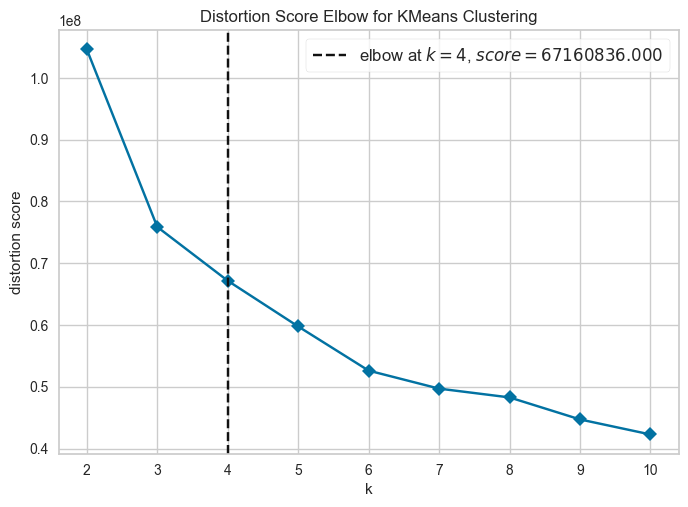

In [206]:
plot_model(best, plot="elbow")        
# plot_model(best, plot="silhouette")   
# plot_model(best, plot="cluster")


In [208]:
clustered = assign_model(best)
clustered["cluster"] = (
    clustered["Cluster"]
    .str.replace("Cluster ", "", regex=False)
    .astype(int)
)
labels = clustered["cluster"].values
clustered.drop(columns=['Cluster'], inplace=True)


In [209]:
clustered.head()


0           1          2          3          4          5  \
0  -5.013672   13.914816  -0.836406   0.331018   0.964762   0.824352   
1 -13.819407   20.041027  -1.177685  -0.288363   0.686438  -1.115452   
2  25.052107 -140.703842  15.374821 -10.454559  -7.206252 -20.137669   
3   9.189611   10.867785  -2.839204  -1.981985 -13.051668   2.041984   
4 -13.853116   20.263784   0.625104  -1.346178   0.444663   0.227029   

           6          7          8         9        10        11        12  \
0  -1.159272  -1.304118  -1.707820  0.644383  1.063920 -0.600436 -6.600870   
1  -0.090843   1.269612  -0.214637 -0.895341 -0.242527 -1.009771  2.547321   
2 -23.644190  15.607669  18.430399 -9.205523  0.647507 -0.711364  2.559112   
3  -0.996341   1.170234   1.183415 -0.494800  0.364304  5.007380 -2.077611   
4  -0.165629   0.585994   0.590716 -0.785591 -0.199747 -1.022208  2.930861   

   cluster  
0        0  
1        0  
2        1  
3        0  
4        0

In [210]:
pd.Series(labels).value_counts().sort_index()


0    26128
1     1940
2     3810
3      224
Name: count, dtype: int64

In [211]:
plot_results(clustered)


In [212]:
users.columns


Index(['user_id', 'odds_log_mean_mean_2d', 'odds_log_mean_std_2d',
       'odds_log_mean_mean_7d', 'odds_log_mean_std_7d',
       'odds_log_mean_mean_14d', 'odds_log_mean_std_14d',
       'odds_log_mean_mean_30d', 'odds_log_mean_std_30d',
       'odds_log_std_mean_2d',
       ...
       'slope_odd_day_mean_30d', 'slope_odd_day_std_30d',
       'n_bet_proportion_mean_2d', 'n_bet_proportion_std_2d',
       'n_bet_proportion_mean_7d', 'n_bet_proportion_std_7d',
       'n_bet_proportion_mean_14d', 'n_bet_proportion_std_14d',
       'n_bet_proportion_mean_30d', 'n_bet_proportion_std_30d'],
      dtype='object', length=137)

In [213]:
cluster_labels = pd.Series(labels, name="cluster")
cluster_labels[0]

labeled_users = users.copy()
labeled_users['cluster_label'] = cluster_labels


In [214]:
labeled_users.head()


user_id  odds_log_mean_mean_2d  odds_log_mean_std_2d  odds_log_mean_mean_7d  \
0      44               0.055120              0.012787               0.131939   
1      46               0.349807              0.000000               0.349807   
2    5588               1.072452              0.018466               0.944114   
3    5977               0.463704              0.074879               0.824962   
4    7612               0.165514              0.000000               0.165514   

   odds_log_mean_std_7d  odds_log_mean_mean_14d  odds_log_mean_std_14d  \
0              0.097646                0.138996               0.146927   
1              0.000000                0.349807               0.000000   
2              0.111931                0.983297               0.267010   
3              0.870706                0.731960               0.750704   
4              0.000000                0.165514               0.000000   

   odds_log_mean_mean_30d  odds_log_mean_std_30d  odds_log_std_mean_2d  ...  \
0                0.138996               0.146927              0.050967  ...   
1                0.349807               0.000000              0.588818  ...   
2                0.962997               0.233023              0.689501  ...   
3                0.731960               0.750704              0.375826  ...   
4                0.165514               0.000000              0.000000  ...   

   slope_odd_day_std_30d  n_bet_proportion_mean_2d  n_bet_proportion_std_2d  \
0               0.008597                  1.282375                 0.436275   
1               0.000000                  1.000000                 0.000000   
2               1.287427                  1.118203                 0.376017   
3               0.009778                  5.492139                 3.419127   
4               0.000000                  1.000000                 0.000000   

   n_bet_proportion_mean_7d  n_bet_proportion_std_7d  \
0                  1.576553                 0.677132   
1                  1.000000                 0.000000   
2                  0.802359                 0.566608   
3                  2.736390                 2.587291   
4                  1.000000                 0.000000   

   n_bet_proportion_mean_14d  n_bet_proportion_std_14d  \
0                   1.685357                  1.150637   
1                   1.000000                  0.000000   
2                   0.648897                  0.588042   
3                   2.215473                  2.306298   
4                   1.000000                  0.000000   

   n_bet_proportion_mean_30d  n_bet_proportion_std_30d  cluster_label  
0                   1.685357                  1.150637              0  
1                   1.000000                  0.000000              0  
2                   0.708415                  0.562243              1  
3                   2.215473                  2.306298              0  
4                   1.000000                  0.000000              0  

[5 rows x 138 columns]

In [ ]:
labeled_users.to_parquet('data/labeled_users.parquet',engine='fastparquet')


In [ ]:

users = pd.read_parquet('data/users.parquet',engine='fastparquet')
daily_features = pd.read_parquet('data/daily.parquet',engine='fastparquet')
labeled_users = pd.read_parquet('data/labeled_users.parquet',engine='fastparquet')


In [ ]:
# clusters = (
#     labeled_users
#     .groupby(['cluster_label'], observed=True)
#     .mean(numeric_only=True)
#     .reset_index()
# )


# clusters


cluster_label  odds_log_mean_mean_2d  odds_log_mean_std_2d  \
0              0               0.563971              0.062793   
1              1               0.558748              0.066318   
2              2               0.534922              0.093048   
3              3               0.543386              0.118981   

   odds_log_mean_mean_7d  odds_log_mean_std_7d  odds_log_mean_mean_14d  \
0               0.563625              0.083275                0.563561   
1               0.557188              0.100357                0.553376   
2               0.532924              0.138404                0.532711   
3               0.546376              0.199903                0.545389   

   odds_log_mean_std_14d  odds_log_mean_mean_30d  odds_log_mean_std_30d  \
0               0.084410                0.563567               0.084536   
1               0.111237                0.552711               0.115173   
2               0.144461                0.532423               0.145603   
3               0.199856                0.545389               0.199856   

   odds_log_std_mean_2d  ...  slope_odd_day_mean_30d  slope_odd_day_std_30d  \
0              0.292653  ...               -0.003577               0.031284   
1              0.339584  ...               -0.169659               1.007956   
2              0.332517  ...               -0.005077               0.238451   
3              0.291136  ...               -0.092434               0.430541   

   n_bet_proportion_mean_2d  n_bet_proportion_std_2d  \
0                  1.227571                 0.390214   
1                  1.605396                 1.016135   
2                  1.475412                 0.957714   
3                 35.535566                33.392935   

   n_bet_proportion_mean_7d  n_bet_proportion_std_7d  \
0                  1.241421                 0.569497   
1                  2.525555                 2.916577   
2                  1.799698                 1.994842   
3                 41.879158                60.313554   

   n_bet_proportion_mean_14d  n_bet_proportion_std_14d  \
0                   1.268655                  0.638849   
1                   2.889615                  3.996515   
2                   1.984677                  2.508758   
3                  42.646257                 64.081900   

   n_bet_proportion_mean_30d  n_bet_proportion_std_30d  
0                   1.274856                  0.656791  
1                   3.356581                  5.652269  
2                   2.097608                  2.845819  
3                  42.646257                 64.081900  

[4 rows x 137 columns]

In [218]:
bets_df = bets.merge(labeled_users[['user_id', 'cluster_label']], on='user_id', how='left')


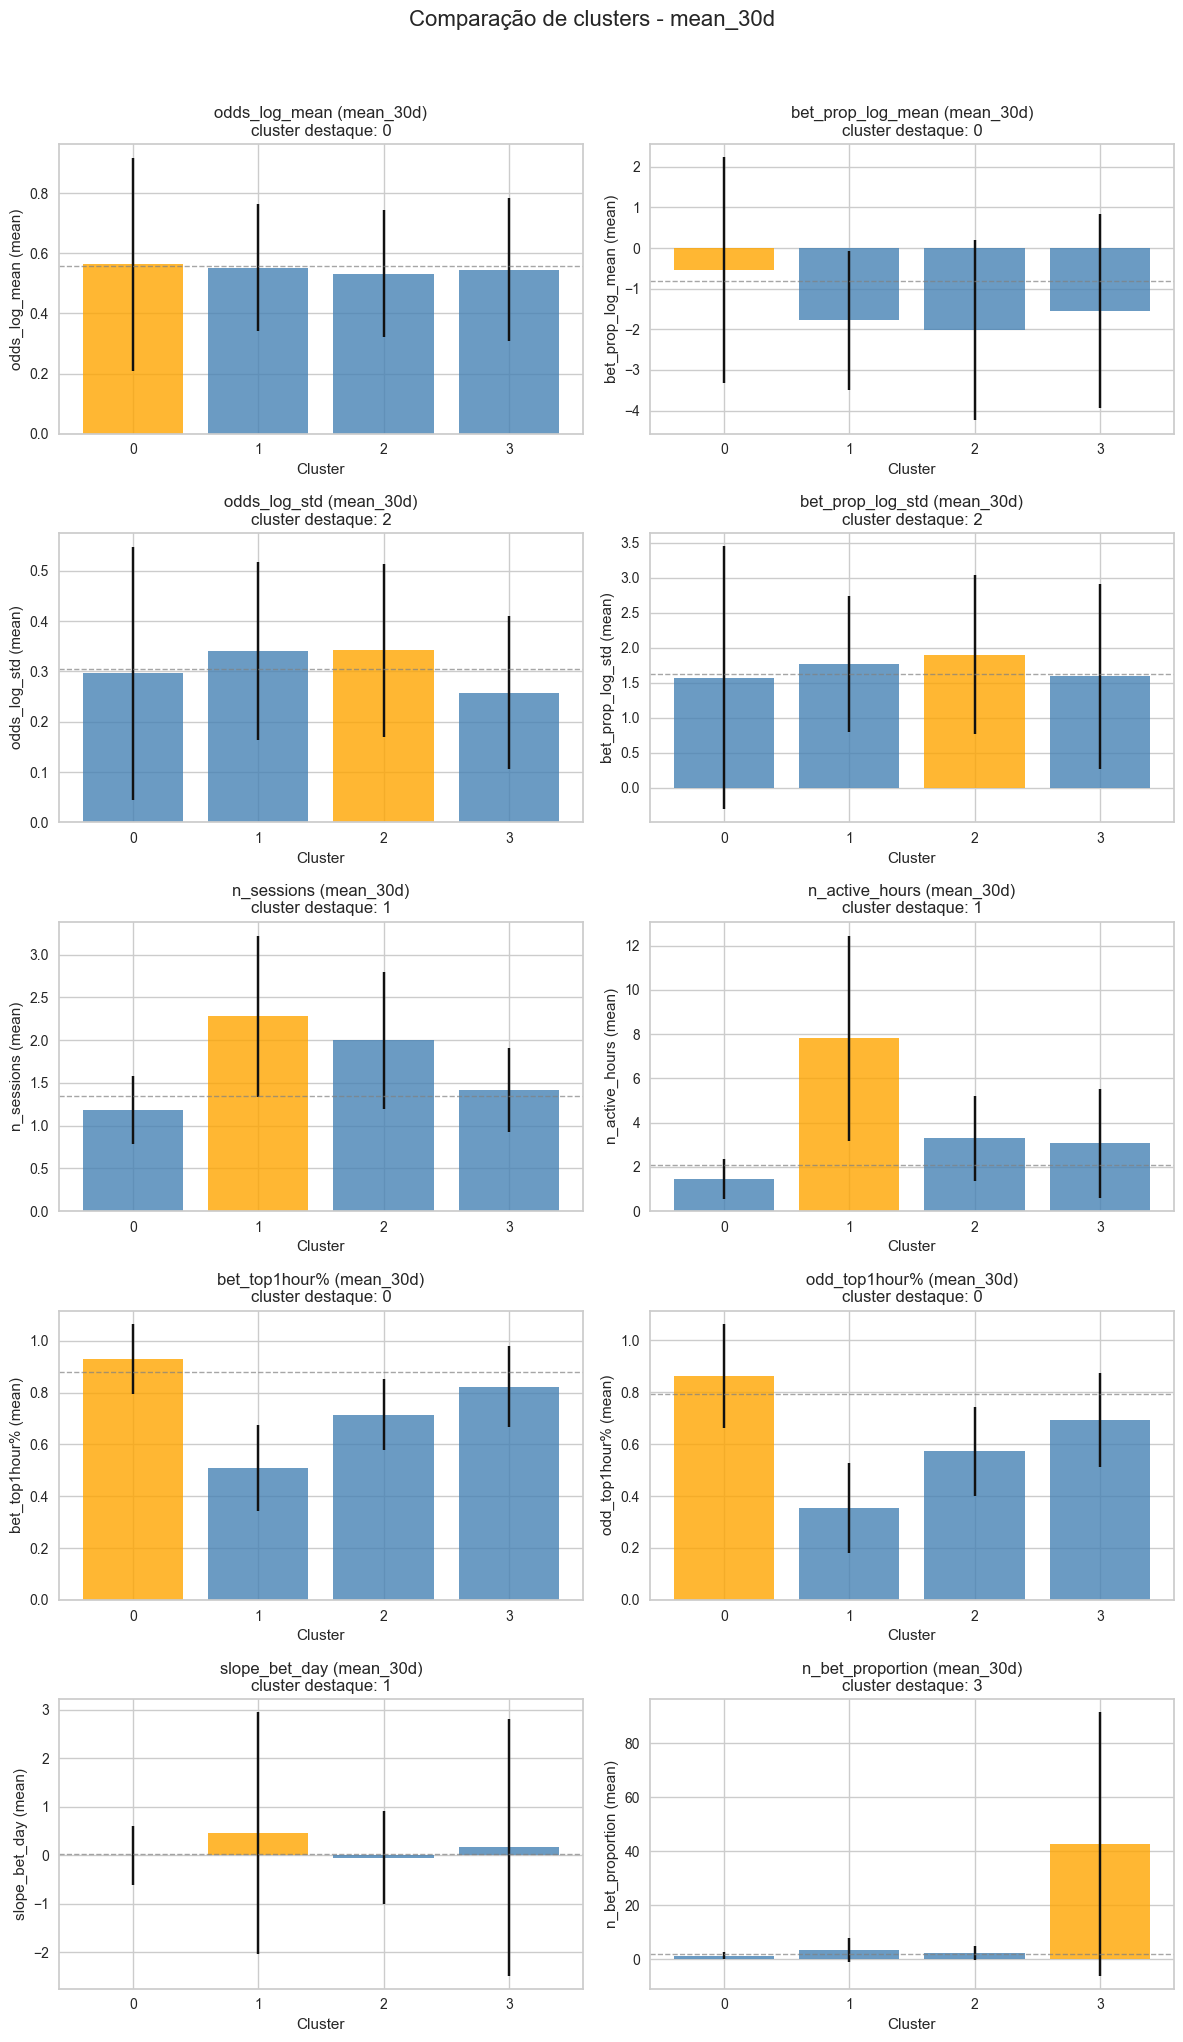

In [228]:
features = [
    "odds_log_mean",
    "bet_prop_log_mean",
    "odds_log_std",
    "bet_prop_log_std",
    "n_sessions",
    "n_active_hours",
    "bet_top1hour%",
    "odd_top1hour%",
    "slope_bet_day",
    "n_bet_proportion"
]

plot_cluster_feature_comparisons(
    df=labeled_users,            
    features=features,
    window="30d",
    stat="mean",
    cluster_col="cluster_label",
)


### 14 - Mean
#### Cluster 2: 
 - tem uma proporcao de quantidade de bets muito maior, teoria: usuarios desse cluster tem a tendencia a apostar varias vezes no dia
 - tambem tem um slope desvio padrao alto, oq indica que comeca o dia apostando um valor, e termina apostando cada vez mais
    
"103399"

#### Cluster 3:
 - Numero de sessoes maior, oq indica que passa a maior parte do dia jogando..., tambem tem um numero de horas ativas alto.

#### Cluster 4:
 - Horas ativas altas e Slope alto tambem, o mais problematico ai q ta tendo




In [130]:
columns = [col for col in labeled_users.columns if 'bet_prop_mean' in col and 'mean' in col]
tst = labeled_users[labeled_users['cluster_label'] == 1][['user_id']+columns]
tst


user_id  bet_prop_mean_mean_2d  bet_prop_mean_std_2d  \
9        14485               1.867998              0.132836   
10       14857              -2.847780              1.353085   
19       26655              -4.086266              3.946474   
43       46079              -0.411320              0.284328   
44       46087              -0.591078              0.014259   
...        ...                    ...                   ...   
31870  1502299              -0.048736              2.338500   
31898  1502445               3.443132              0.703001   
31929  1502634               1.109925              0.245181   
31941  1502698               1.405835              0.917491   
31946  1502714              -1.794388              1.657335   

       bet_prop_mean_mean_7d  bet_prop_mean_std_7d  bet_prop_mean_mean_14d  \
9                   3.500714              2.521269                3.500714   
10                 -1.069652              2.193582               -1.069652   
19                 -4.086266              3.946474               -4.086266   
43                 -0.404575              1.513871               -0.536581   
44                 -1.892971              1.113401               -1.952836   
...                      ...                   ...                     ...   
31870              -0.048736              2.338500               -0.048736   
31898               3.443132              0.703001                3.443132   
31929               1.109925              0.245181                1.109925   
31941               1.405835              0.917491                1.405835   
31946              -1.794388              1.657335               -1.794388   

       bet_prop_mean_std_14d  
9                   2.521269  
10                  2.193582  
19                  3.946474  
43                  3.420309  
44                  0.897046  
...                      ...  
31870               2.338500  
31898               0.703001  
31929               0.245181  
31941               0.917491  
31946               1.657335  

[3537 rows x 7 columns]

In [135]:
user_id = 46079


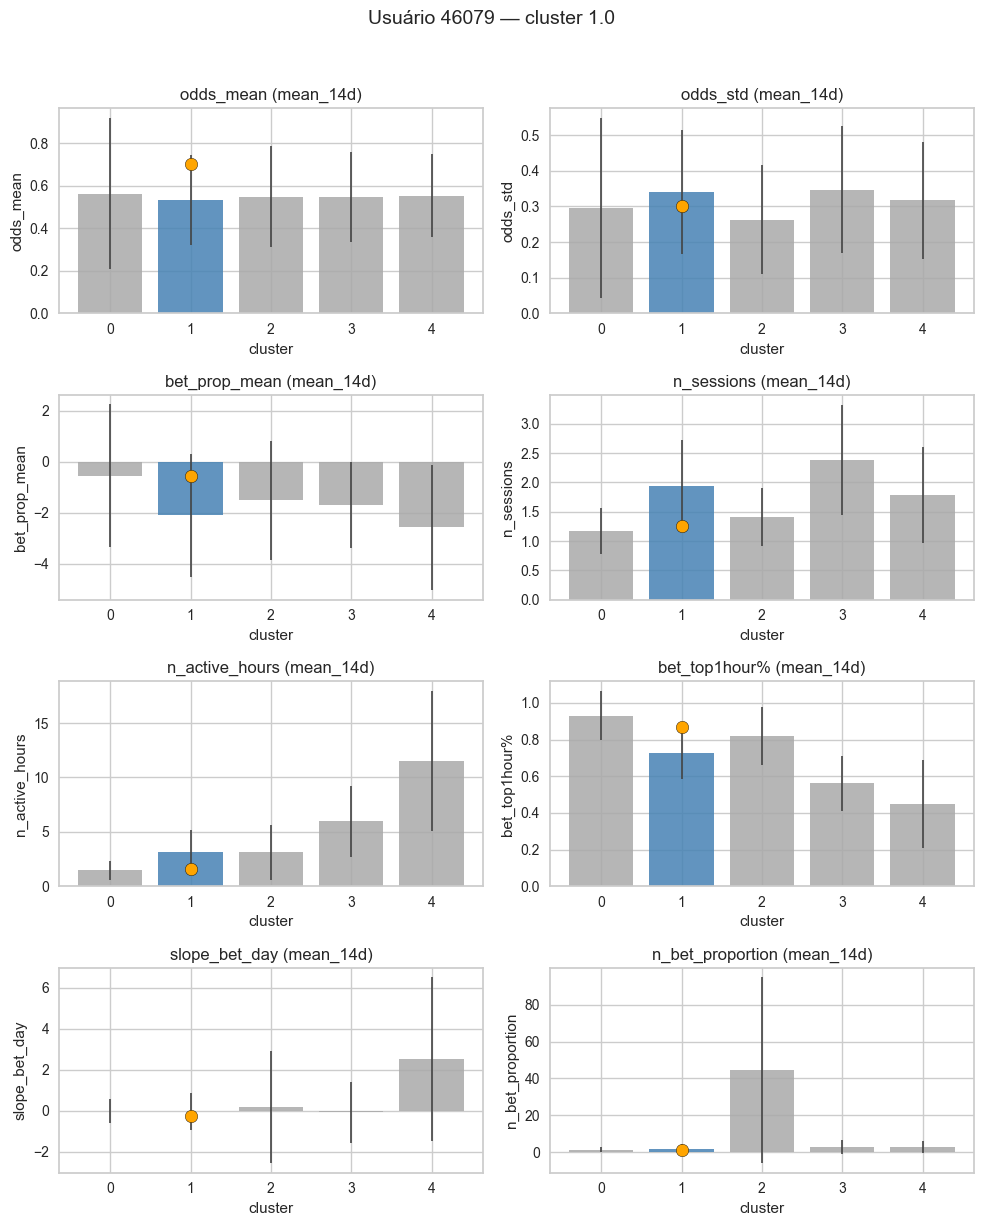

In [136]:
features = [
    "odds_mean",
    "odds_std",
    "bet_prop_mean",
    "n_sessions",
    "n_active_hours",
    "bet_top1hour%",
    # "odd_top1hour%",
    "slope_bet_day",
    "n_bet_proportion"
]

plot_user_vs_clusters(
    df_users=labeled_users,  
    user_id=user_id,
    features=features,
    window="14d",
    stat="mean",
)


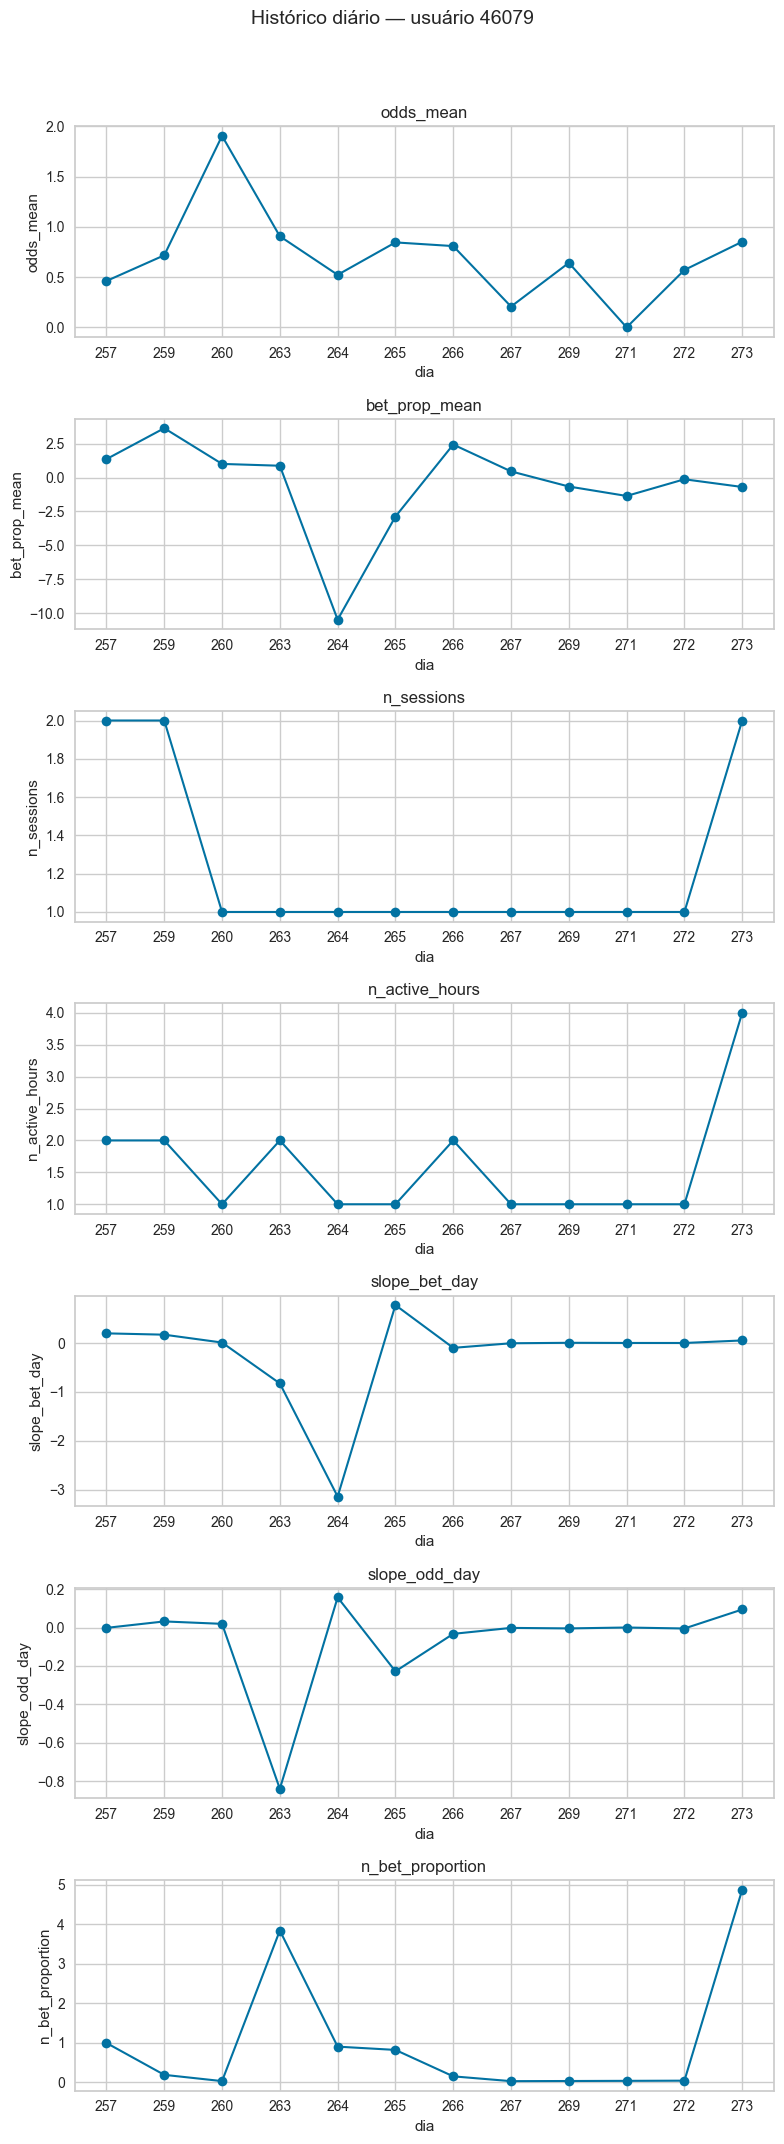

In [137]:
daily_feats = [
    'odds_mean', 
    # 'odds_std', 
    'bet_prop_mean',
    # 'bet_prop_std', 
    'n_sessions', 'n_active_hours', 
    # 'bet_top1hour%', 'bet_top2hours%', 'odd_mean_abs_dev_uniform%', 
    'slope_bet_day', 'slope_odd_day', 'n_bet_proportion',
]

plot_user_daily(daily_features, user_id=user_id, features=daily_feats)


In [138]:
day = 257


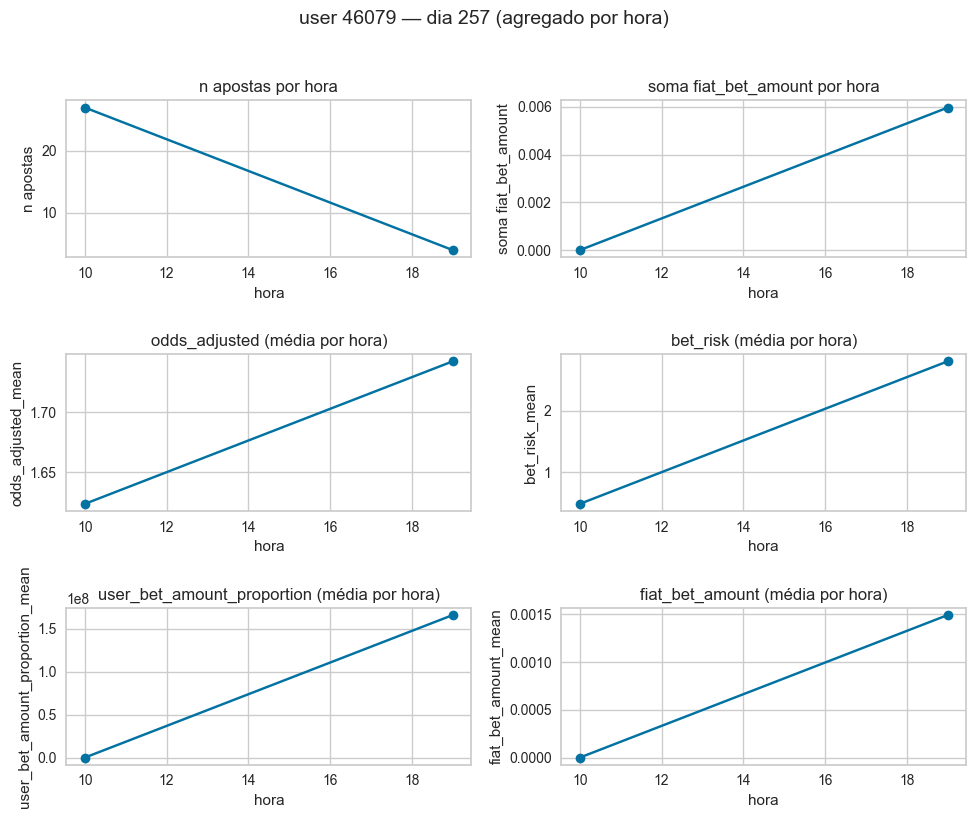

In [139]:
plot_user_day_hourly(
    df=bets,          
    user_id=user_id,
    day_of_year=day  
)


In [141]:
hour = 10


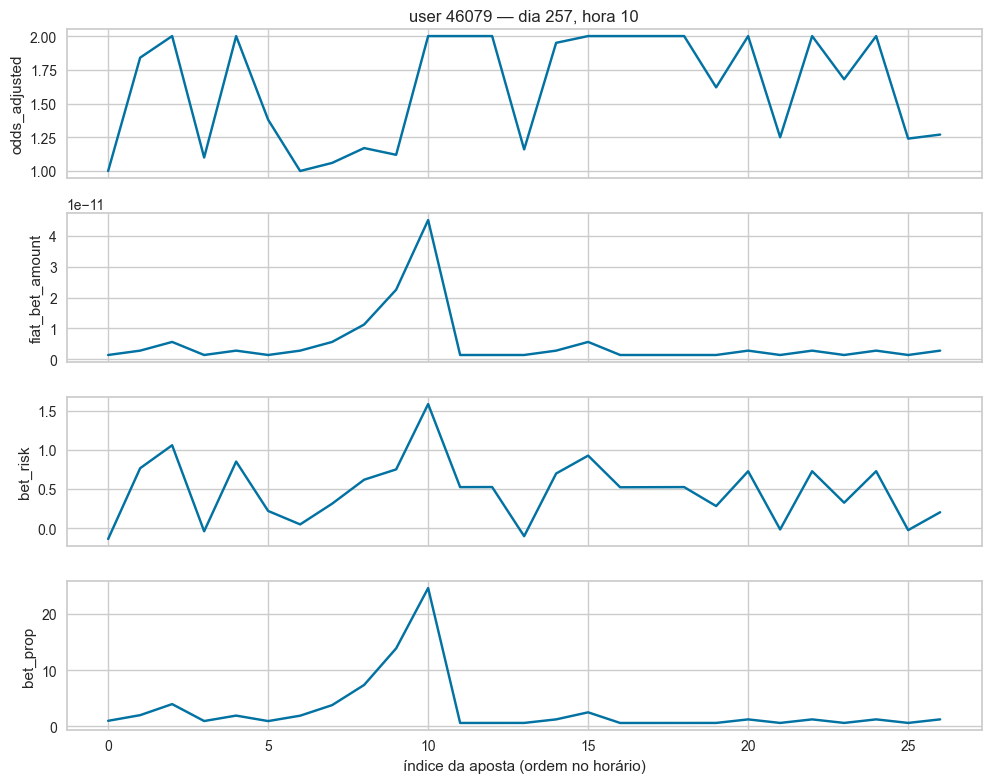

In [142]:
plot_user_hour_bets(
    df=bets,          
    user_id=user_id,
    day_of_year=day,   
    hour=hour  
)


In [102]:
remaining = clustered[clustered['cluster'] == 0]
remaining.drop(columns=['cluster'],inplace=True)


In [103]:
plot_pca(remaining,4)


In [104]:
s = setup(data=remaining, session_id=123)


In [113]:

best = create_model("kmeans", num_clusters = 6)
results = pull()


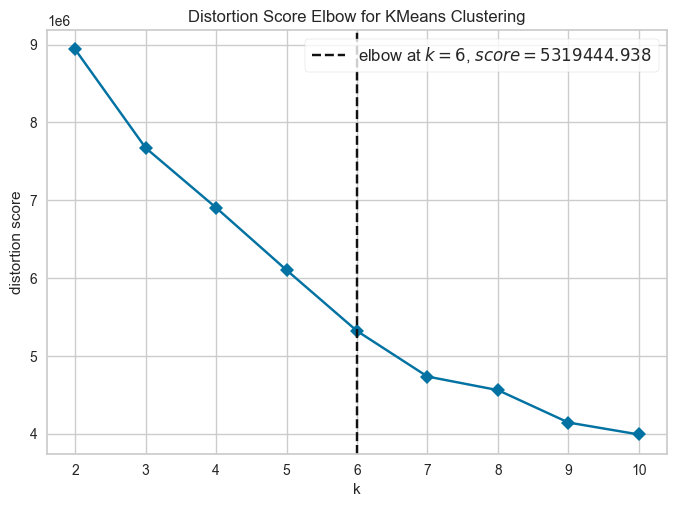

In [106]:
plot_model(best, plot="elbow")  


In [114]:
clustered = assign_model(best)
clustered["cluster"] = (
    clustered["Cluster"]
    .str.replace("Cluster ", "", regex=False)
    .astype(int)
)
labels = clustered["cluster"].values
clustered.drop(columns=['Cluster'], inplace=True)


In [115]:
clustered


0          1         2         3          4         5  \
0      -6.323800  13.934855 -0.821720 -0.548798   1.102720  1.052687   
1     -14.181232  18.158266 -1.119826  0.448723   0.599797 -0.952738   
3       8.857280  10.963748 -2.932715 -0.260671 -12.650561  1.527481   
4     -14.216159  18.308174  0.375877  1.408960   0.262572  0.170585   
5     -13.941021  17.452551 -0.737206 -0.026345   0.783365 -2.179879   
...          ...        ...       ...       ...        ...       ...   
32097 -14.228089  18.337507 -0.139465  1.131186   0.370560 -0.254244   
32098 -14.257106  18.405249 -0.621989  0.951997   0.425673 -0.118667   
32099 -14.125504  18.081181  1.992268  1.977476   0.063991  0.629725   
32100 -14.217487  18.311062  0.361861  1.405334   0.263110  0.194188   
32101 -14.217170  18.310612  0.366217  1.406031   0.263403  0.184981   

              6         7  cluster  
0      1.357347 -0.958559        0  
1     -0.048364  1.047310        0  
3      0.857335  1.139288        3  
4      0.202791  0.550645        0  
5     -1.284578 -0.031271        0  
...         ...       ...      ...  
32097  0.533406  1.089505        0  
32098  0.263000  1.012489        0  
32099  0.415166 -0.011790        0  
32100  0.174772  0.527596        0  
32101  0.184853  0.537163        0  

[25905 rows x 9 columns]

In [120]:
pd.Series(labels).value_counts().sort_index()


0    23338
1      233
2      129
3     1274
4      518
5      413
Name: count, dtype: int64

In [125]:
plot_results(clustered)


In [117]:
cluster_labels = pd.Series(labels, name="cluster")


In [118]:
labeled_users2 = users.copy()
labeled_users2['cluster_label'] = cluster_labels
labeled_users2 = labeled_users2.dropna()


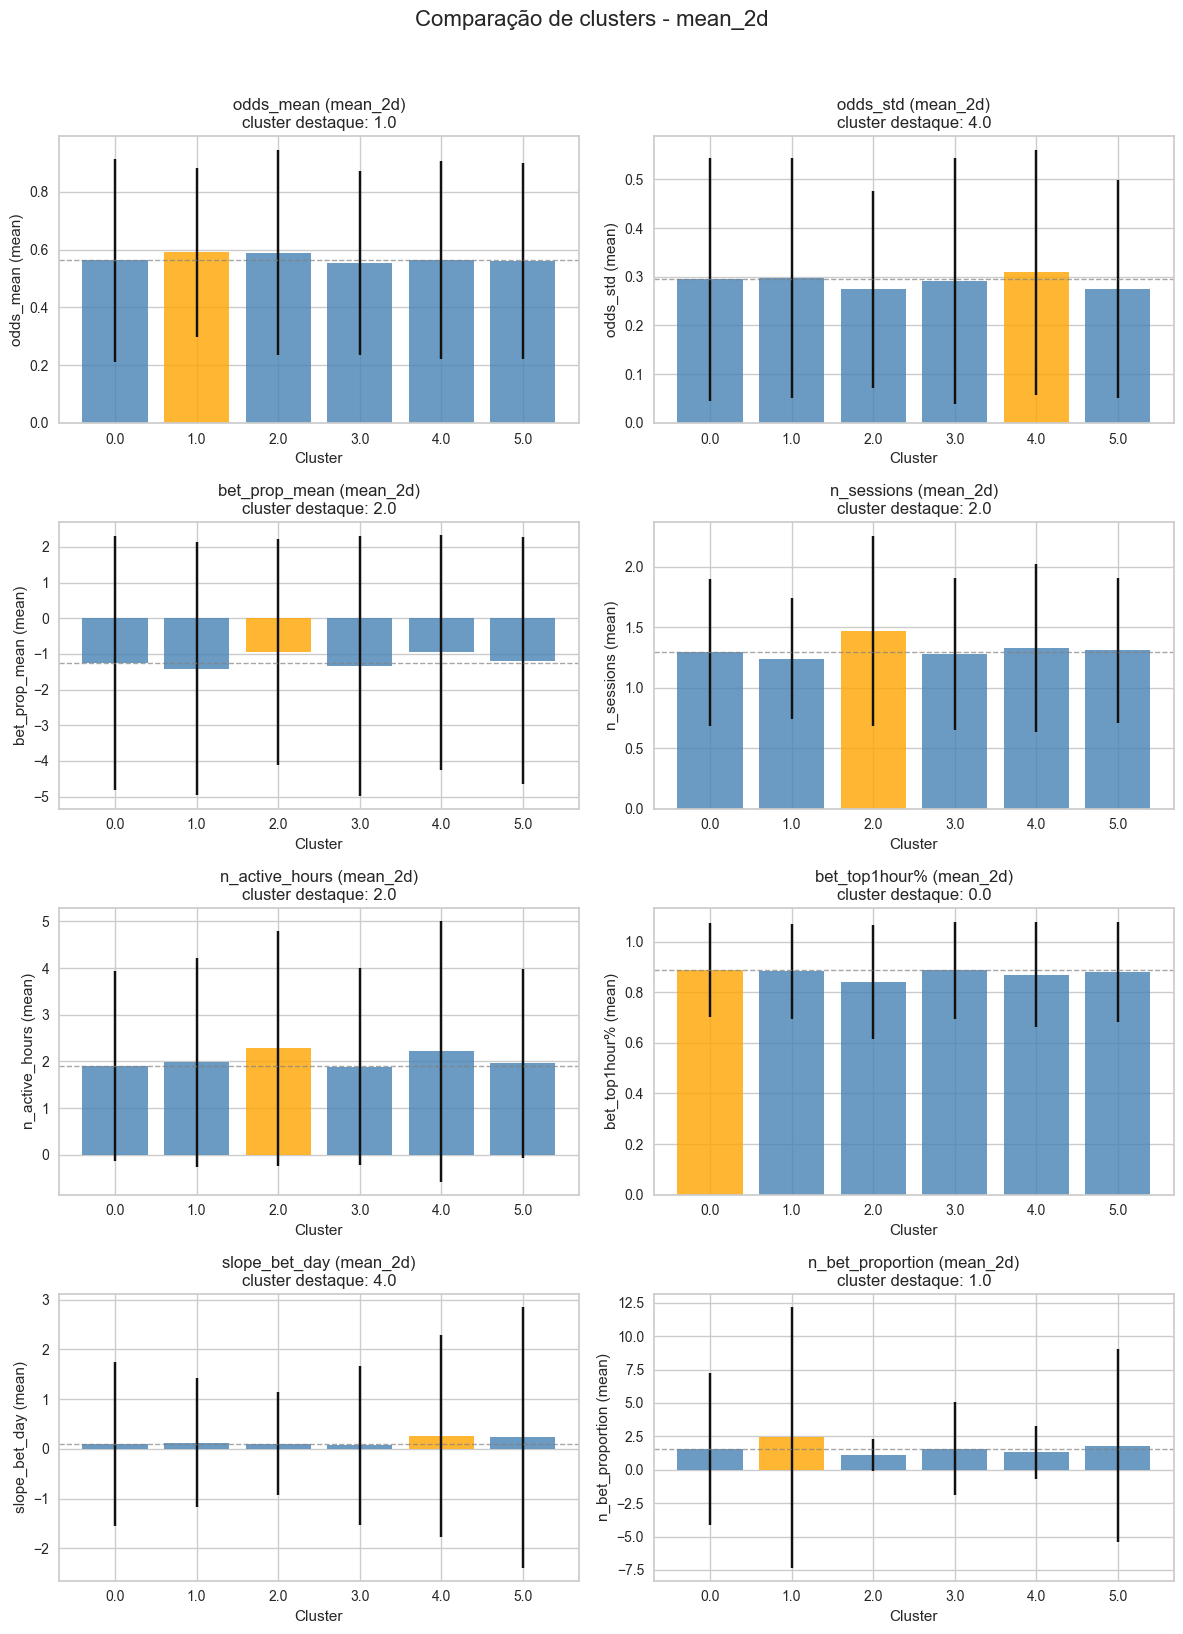

In [119]:
features = [
    "odds_mean",
    "odds_std",
    "bet_prop_mean",
    "n_sessions",
    "n_active_hours",
    "bet_top1hour%",
    # "odd_top1hour%",
    "slope_bet_day",
    "n_bet_proportion"
]

plot_cluster_feature_comparisons(
    df=labeled_users2,            
    features=features,
    window="2d",
    stat="mean",
    cluster_col="cluster_label",
)


In [229]:
daily_features


user_id  day_of_year  odds_log_mean  odds_log_std  bet_prop_log_mean  \
0            44          253       0.045360      0.027368           0.000000   
1            44          254       0.537515      0.259239           1.242422   
2            44          255       0.029559      0.000000          -0.069071   
3            44          257       0.036531      0.027343           0.324303   
4            44          259       0.095418      0.104053          -0.068377   
...         ...          ...            ...           ...                ...   
130639  1503508          274       0.469348      0.309348           1.480713   
130640  1503513          274       0.192760      0.105671           2.745244   
130641  1503516          274       0.386987      0.334752          -8.095021   
130642  1503542          274       0.165514      0.000000           0.000000   
130643  1503546          274       0.239017      0.000000           0.000000   

        bet_prop_log_std  n_sessions  n_active_hours  bet_top1hour%  \
0               0.000000         1.0               2       0.500000   
1               0.736760         1.0               2       0.825483   
2               0.000000         1.0               1       1.000000   
3               0.698184         3.0               3       0.559135   
4               0.002970         1.0               1       1.000000   
...                  ...         ...             ...            ...   
130639          2.308513         1.0               1       1.000000   
130640          2.152429         1.0               1       1.000000   
130641         10.176622         1.0               1       1.000000   
130642          0.000000         1.0               1       1.000000   
130643          0.000000         1.0               1       1.000000   

        bet_top2hours%  bet_top4hours%  bet_mean_abs_dev_uniform%  \
0             1.000000        1.000000                   0.076389   
1             1.000000        1.000000                   0.076389   
2             1.000000        1.000000                   0.079861   
3             0.782729        0.782729                   0.072917   
4             1.000000        1.000000                   0.079861   
...                ...             ...                        ...   
130639        1.000000        1.000000                   0.079861   
130640        1.000000        1.000000                   0.079861   
130641        1.000000        1.000000                   0.079861   
130642        1.000000        1.000000                   0.079861   
130643        1.000000        1.000000                   0.079861   

        odd_top1hour%  odd_top2hours%  odd_top4hours%  \
0            0.505995        1.000000        1.000000   
1            0.515239        1.000000        1.000000   
2            1.000000        1.000000        1.000000   
3            0.338710        0.670968        0.670968   
4            1.000000        1.000000        1.000000   
...               ...             ...             ...   
130639       1.000000        1.000000        1.000000   
130640       1.000000        1.000000        1.000000   
130641       1.000000        1.000000        1.000000   
130642       1.000000        1.000000        1.000000   
130643       1.000000        1.000000        1.000000   

        odd_mean_abs_dev_uniform%  slope_bet_day  slope_odd_day  \
0                        0.076389       0.000000       0.001335   
1                        0.076389      -0.029744      -0.013300   
2                        0.079861      -0.000210       0.000090   
3                        0.072917       0.001503       0.000293   
4                        0.079861      -0.009365       0.013068   
...                           ...            ...            ...   
130639                   0.079861      -0.042490      -0.013468   
130640                   0.079861      -0.064454      -0.004526   
130641                   0.079861       0.095029      -0.004543   
130642    